In [ ]:
%matplotlib inline
%reload_ext memory_profiler
import scipy.io as sio
import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import time
import memory_profiler
from random import randint
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.decomposition import PCA, IncrementalPCA
from cw1_library import *
from cw1_library import pca as our_pca
from sklearn.preprocessing import normalize

#######################
%reload_ext autoreload
%autoreload 2
np.random.seed(0) #for reproducibility (NOTE: notebook has)

In [ ]:
# DEFINE CONSTANTS
picH = 56
picW = 46
SAMPLES = 520
FIGURE_NO = 1

In [ ]:
# IMPORT DATASET
FILENAME = os.path.join(os.getcwd(), "face.mat")
dataset = sio.loadmat(FILENAME)
faces = np.array(dataset["X"]).transpose()
for i in range(len(faces)):
    faces[i] = np.rot90(np.array(faces[i]).reshape(picW, picH), k=-1).reshape(picW*picH)
labels = np.array(dataset["l"]).transpose().reshape(SAMPLES)


print("Faces imported:  {}\tShape of each face: {}".format(faces.shape[0], faces[0].shape))
print("Labels imported: {}\tSamples per class:  10".format(labels.shape[0]))

In [ ]:
# SHOW EXAMPLE FACES
for i in range(10):
    plt.subplot(2,5,i+1)
    index = i*10
    show_image(faces[index], label="Face: {}".format(labels[index]), independent=False)

In [ ]:
# SPLIT DATASET INTO TRAINING AND TEST SETS (80 - 20)
# NOTE: this process mantains class balance

train_faces, train_labels, test_faces, test_labels = train_test_split(faces, labels)

print("Training set --->", len(train_faces), "samples")
print("Test set ------->", len(test_faces), "samples")

# Q1. [15] Computationally Efficient Eigenfaces
Partition the provided face data into your training and testing data, e.g. 8 images and 2 other images of each face identity for training and testing respectively.

Apply PCA to your training data i.e. compute the eigenvectors and eigenvalues of the covariance matrix S=(1/N)AA<sup>T</sup> directly, and use the low-dimensional computation of eigenspace i.e. using (1/N)A<sup>T</sup>A of your training data.

Show and discuss, in comparison, including: the eigenvectors and eigenvalues, the mean image, how many eigenvectors are with non-zero eigenvalues, if the eigenvectors and eigenvalues obtained by the two methods are identical, what are the pros/cons of each method. Give physical meanings and show respective measurements for your answers.

**Hereinafter, we use the low-dimensional PCA technique.**

Do face image reconstruction while varying the number of PCA bases learnt. Show and discuss the results quantitatively and qualitatively for different face images.

Perform PCA-based face recognition by the NN classification. Report and discuss, including: recognition accuracies (success rates), example success and failure cases, the confusion matrices, time/memory, by varying the parameter values. Give insights and reasons behind your observations.

### Plot mean and std dev for diff n_pc

In [ ]:
n_pc_range = np.arange(1,416,2)
means = []
# std_devs = []
for i in tqdm(range(len(n_pc_range))):
    mean, std_dev = get_reconstruction_error(train_faces, n_pc_range[i])
    means.append(mean)
#     std_devs.append(std_dev)

In [ ]:
# plt.errorbar(n_pc_range, means, std_devs, linestyle='None')
# plt.errorbar(n_pc_range, means, std_devs, marker='^')
plt.plot(n_pc_range, means)
plt.title("Reconstruction error vs M")
plt.xlabel("Number of Principal Components (M)")
plt.ylabel("Reconstruction error")
plt.grid()
plt.show()

### Generate covariance matrices & eigenthings

In [ ]:
mean = np.mean(train_faces, axis=0)
centered_data = train_faces-mean
centered_data = centered_data.T
num_samples = centered_data.shape[1]

start = time.process_time()

cov_matrix = (1/num_samples)*np.dot(centered_data, centered_data.T)    # Reg approach (1/N)AAT
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

middle = time.process_time()

cov_matrix_ld = (1/num_samples)*np.dot(centered_data.T, centered_data)     # Low dimensional approach (1/N)ATA
eig_vals_ld, eig_vecs_ld = np.linalg.eig(cov_matrix_ld)

duration_ld = time.process_time() - middle
duration = middle - start

eig_vals = np.real(eig_vals)
eig_vecs = np.real(eig_vecs)

eig_vals_ld = np.real(eig_vals_ld)   
eig_vecs_ld = np.real(eig_vecs_ld)

#Sort eigenstuff from greatest to smallest
idx = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idx]   # <-- This sorts the list in place.
eig_vecs = eig_vecs[:, idx]

idx_ld = eig_vals_ld.argsort()[::-1]
eig_vals_ld = eig_vals_ld[idx_ld]     
eig_vecs_ld = eig_vecs_ld[:, idx_ld]

In [ ]:
show_image(np.dot(centered_data, eig_vecs_ld[0]))
# SHOW Eigenfaces 

normed = normalize(eig_vecs, axis=1, norm='l1')

for i in range(25):
    plt.subplot(5,5,i+1)
    show_image(normed[:,i], independent=False, axis=False)

In [ ]:
# SHOW Eigenfaces low dim
from sklearn.metrics.pairwise import cosine_similarity
                                           
normed_ld = normalize(eig_vecs_ld, axis=1, norm='l1')


tmp = np.dot(-1,np.dot(centered_data, normed_ld))
A = cosine_similarity(normed[:,:416].T, tmp.T)
# A = cosine_similarity(normed[:,:416].T, normed_ld.T)


print(A.shape)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111) 
cb = ax.matshow(A, cmap="viridis")
fig.colorbar(cb)
plt.show()
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     show_image(np.dot(np.dot(centered_data, normed_ld[:,i]),1), independent=False, axis=False)

### Plot eigenstuff for both matrices

In [ ]:
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(211)
ax.title.set_text('Eigenvalues of S')
ax2 = f.add_subplot(212)
ax2.title.set_text('Eigenvalues of $S_{LD}$')

n_eigen_vals = 25

ax.bar(range(n_eigen_vals), eig_vals[:n_eigen_vals])
ax2.bar(range(n_eigen_vals), eig_vals[:n_eigen_vals])

# My intention was to plot eigenvectors - but how to plot vector?

ax.grid()
ax2.grid()
plt.show()

### Nearest Neighbor

In [ ]:
n_pc_range = range(1,416,5)
scores = []
duration = []

for i in tqdm(n_pc_range):
    proj, comp, mean, centered_data = pca(train_faces, i)
    test_centered = transform(test_faces, comp, mean)
    
    start = time.perf_counter()
    scores.append(get_classification_score(proj, train_labels, test_centered, test_labels))
    duration.append(time.perf_counter() - start)


# print(scores)
# print(scores2)

In [ ]:
n_pc_range = range(1,416,5)

mem_usage = []
base_mem = memory_profiler.memory_usage()[0]
print("BASE MEMORY:",base_mem,"MB")
for i in tqdm((n_pc_range), total=len(n_pc_range)):
    %reload_ext memory_profiler
    try:
        mem = memory_profiler.memory_usage((nn_pca_classifier, (train_faces,train_labels,
                                                                test_faces, test_labels,
                                                                i)), 
                                           interval=0.000001, 
                                           include_children=True,
                                           multiprocess=True)
    except:
        if i>0:
            mem_usage[i] = mem_usage[i-1]
        else:
            mem_usage[i] 
            
    mem_usage.append(max(mem)-base_mem)

In [ ]:
f = plt.figure(figsize=(12,12))

ax = f.add_subplot(131)
ax.plot(n_pc_range, scores)
ax.title("Accuracy of KNN classifier")
ax.xlabel("Number of Principal Components")
ax.ylabel("Test Accuracy")
ax.grid()

ax2 = f.add_subplot(132)
ax2.plot(n_pc_range, duration)
ax2.title("Duration of classification")
ax2.xlabel("Number of Principal Components")
ax2.ylabel("Time taken to compute accuracy")
ax2.grid()

ax3 = f.add_subplot(133)
ax3.plot(n_pc_range, mem_usage)
ax3.title("Memory Usage")
ax3.xlabel("Number of Principal Components")
ax3.ylabel("Memory usage (MB)")
ax3.grid()
ax3.show()

In [ ]:
n_pc_range = range(1,416,5)
scores = []
scores2 = []

for i in tqdm(n_pc_range):
    proj, comp, mean, centered_data = pca(train_faces, i)
    test_centered = transform(test_faces, comp, mean)
    
    scores.append(get_classification_score(proj, train_labels, test_centered, test_labels))
    scores2.append(get_classification_score(train_faces, train_labels, test_faces, test_labels))


plt.plot(n_pc_range, scores)
plt.plot(n_pc_range, scores2)
plt.title("Accuracy of KNN classifier")
plt.xlabel("Value for K")
plt.ylabel("Test Accuracy")

In [ ]:
from resource import *

print(getrusage(RUSAGE_SELF)[3])

# Q2. [15] Incremental PCA
Use the same data partition into training and testing as in Q1. Further divide the training data equally into four subsets, each with 104 images (i.e. two images per person). Starting with the first subset, keep adding a more subset into your training.

Perform Incremental PCA, and compare it with the counterpart i.e. batch PCA, and PCA trained only by the first subset, in terms of training time, reconstruction error, face recognition accuracy.

Show and discuss, including: how accurate your incremental method is, what important parameters in the method are (and how they are set). Provide your own discussions and measurements to support.

In [ ]:
# Split train data into 4 mini-batches
x_split,y_split = split_dataset(train_faces, train_labels, 4)

print("x_split shape:", x_split.shape)
print("y_split shape:", y_split.shape)

dataset_partitions = [1,2,3,4]
n_partitions, n_samples, n_features = x_split.shape

x_unified_minibatches = [[],[],[],[]]
y_unified_minibatches = [[],[],[],[]]
for n_dataset_to_use in dataset_partitions: #1,2,3,4 quarter of dataset at the same time 
    x_train = np.array([], dtype=int)
    y_train = np.array([], dtype=int)
    for i in range(n_dataset_to_use):# for each quarter dataset
        x_train = np.append(x_train, x_split[i]) # add Dset partition to main train set
        y_train = np.append(y_train, y_split[i]) # same for class labels
    x_train = x_train.reshape((n_dataset_to_use * n_samples, n_features))
    x_unified_minibatches[dataset_partitions.index(n_dataset_to_use)] = x_train
    y_unified_minibatches[dataset_partitions.index(n_dataset_to_use)] = y_train

In [ ]:
# Perform Incremental PCA and batch PCA
# and compare the two methods on training time and classification accuracy

#####################################################
# Set n_pc values to scan through
n_components = list(range(0,105,1))[1:]

#####################################################
iPCA_scores = np.zeros(shape=(len(n_components),n_partitions))
iPCA_training_times = np.zeros(shape=(len(n_components),n_partitions)) # values in ms

PCA_scores = np.zeros(shape=(len(n_components)))
PCA_training_times = np.zeros(shape=(len(n_components)))

max_iter = len(n_components)*len(dataset_partitions)
iter_count = 0
for n_pc in tqdm(n_components):
    # Train and test PCA
    pca = PCA(n_components=n_pc)
    exec_time = time.time()
    pca.fit(train_faces)
    exec_time = time.time() - exec_time
    score = get_classification_score(pca.transform(train_faces), 
                                     train_labels,
                                     pca.transform(test_faces),
                                     test_labels)
    PCA_scores[n_components.index(n_pc)] = score
    PCA_training_times[n_components.index(n_pc)] = exec_time*1000
    # Train and test iPCA
#     iPCA = IncrementalPCA(n_components=n_pc, batch_size=104)
    for n_dataset_to_use in dataset_partitions: #1,2,3,4 quarter of dataset at the same time
        
        iter_count += 1
        print("Scoring exec time and accuracy of configuration",iter_count,"of",max_iter,"...", end="     \r")
        
#         exec_time = time.time()
#         for i in range(n_dataset_to_use):# for each quarter dataset
#             iPCA.partial_fit(x_split[i])  # train iPCA with dataset    
#         exec_time = time.time() - exec_time
        
        x_train = np.array([], dtype=int)
        y_train = np.array([], dtype=int)
        for i in range(n_dataset_to_use):# for each quarter dataset
            x_train = np.append(x_train, x_split[i]) # add Dset partition to main train set
            y_train = np.append(y_train, y_split[i]) # same for class labels
        x_train = x_train.reshape((n_dataset_to_use * n_samples, n_features))
        
        iPCA = IncrementalPCA(n_components=n_pc, batch_size=104)
        exec_time = time.time()
        iPCA.fit(x_train)
        exec_time = time.time() - exec_time
        
        
        # score classification accuracy of model
        score = get_classification_score(iPCA.transform(x_train), 
                                         y_train,
                                         iPCA.transform(test_faces),
                                         test_labels)
        iPCA_scores[n_components.index(n_pc)][n_dataset_to_use-1] = score
        iPCA_training_times[n_components.index(n_pc)][n_dataset_to_use-1] = exec_time*1000
#         print(round(score*100,1), end = "\t")
#         print()
print("\nDONE")

In [ ]:
def dummy_iPCA_train(data, n_pc, b_size=104):
    iPCA = IncrementalPCA(n_components=n_pc, batch_size=b_size)
    iPCA.fit(data)
    
    
def dummy_PCA_train(data, n_pc):
#     pca = PCA(n_components=n_pc)
#     pca.fit(data)
    our_pca(data, n_pc)

    
## DEBUG
n_components = list(range(0,105,10))[1:]
##
    
    
# Perform Incremental PCA and batch PCA
# and compare the two methods on memory consumption

n_partitions, n_samples, n_features = x_split.shape
iPCA_memory = np.zeros(shape=(len(n_components),n_partitions)) # values in MB

PCA_memory = np.zeros(shape=(len(n_components)))

max_iter = len(n_components)*len(dataset_partitions)
iter_count = 0

base_mem = memory_profiler.memory_usage()[0]

for n_pc in tqdm(n_components):
    # Memory test --> PCA
    mem = memory_profiler.memory_usage((dummy_PCA_train, (train_faces, n_pc)), 
                                        interval=0.000001, 
                                        include_children=True,
                                        multiprocess=True)
    PCA_memory[n_components.index(n_pc)]= (max(mem)-base_mem)
    # Memory test --> iPCA
    for n_dataset_to_use in dataset_partitions: #1,2,3,4 quarter of dataset at the same time 
        iter_count += 1
        print("Scoring memory consumption of configuration",iter_count,"of",max_iter,"...", end="     \r")
        x_train = x_unified_minibatches[n_dataset_to_use-1]
        # score classification accuracy of model 
#         base_mem = memory_profiler.memory_usage()[0]
        mem = memory_profiler.memory_usage((dummy_iPCA_train, (x_train, n_pc)), 
                                            interval=0.000001, 
                                            include_children=True,
                                            multiprocess=True)
        iPCA_memory[n_components.index(n_pc)][n_dataset_to_use-1] = (max(mem)-base_mem)

print("\nDONE")

In [ ]:
# fig = plt.figure(1)
# plt.xlabel("Number of principal components")
# plt.ylabel("Classification score (%)")
# for idx in range(len(iPCA_scores.T)):
#     scores_plot = iPCA_scores.T[idx]
#     label = dataset_partitions[idx]
#     plt.plot(n_components, scores_plot*100, label=label)
# plt.plot(n_components, PCA_scores*100, label="Batch PCA")
# plt.legend(title="Minibatches used")
# plt.grid()


# fig = plt.figure(2)
# plt.xlabel("Number of principal components")
# plt.ylabel("Training time (ms)")
# for idx in range(len(iPCA_training_times.T)):
#     times_plot = iPCA_training_times.T[idx]
#     label = dataset_partitions[idx]
#     plt.plot(n_components, times_plot, label=label)
# plt.plot(n_components, PCA_training_times, label="Batch PCA")
# plt.legend(title="Minibatches used")
# plt.grid()


fig = plt.figure(3)
plt.xlabel("Number of principal components")
plt.ylabel("Memory usage (MB)")
for idx in range(len(iPCA_memory.T)):
    memory_plot = iPCA_memory.T[idx]
    label = dataset_partitions[idx]
    plt.plot(n_components, memory_plot, label=label, marker="o")
plt.plot(n_components, PCA_memory, label="Batch PCA", marker="o")
plt.legend(title="Minibatches used")
plt.grid()
plt.show()

In [ ]:
n_components = list(range(0,105,1))[1:]
m = np.where(iPCA_scores == np.amax(iPCA_scores))
print("--- Best iPCA Classification Accuracy ---")
print("Accuracy:       ", round(iPCA_scores[m[0][0]][m[1][0]]*100,3), "%",sep="\t")
print("# of components:", n_components[m[0][0]],sep="\t")
print("Minibatches used:", dataset_partitions[m[1][0]],sep="\t")
print("Training time:  ", round(iPCA_training_times[m[0][0]][m[1][0]],2),"ms", sep="\t")

print("\n")

m = np.where(PCA_scores == np.amax(PCA_scores))
print("--- Best PCA Classification Accuracy ---")
print("Accuracy:       ", round(PCA_scores[m[0][0]]*100,3), "%",sep="\t")
print("# of components:", n_components[m[0][0]],sep="\t")
print("Training time:  ", round(PCA_training_times[m[0][0]],2),"ms", sep="\t")

# Q3. [20] PCA-LDA Ensemble for Face Recognition
Use the provided face data, and the same data partition into training and testing as in Q1.

**PCA-LDA**

Perform the PCA-LDA based face recognition with the NN classifier. Report and discuss, in comparison to PCA method, including:
- recognition accuracies by varying the hyper-parameter values, e.g. M_pca and M_lda
- ranks of the scatter matrices,
- the confusion matrix, example success and failure cases

**PCA-LDA Ensemble**

Show, measure and discuss the results, by varying its parameter values. Give insights and reasons behind your answers, including:
- randomisation in feature space
- the number of base models, the randomness parameter,
- the error of the committee machine vs the average error of the individual models
- fusion rules (majority voting and sum)
- recognition accuracy and confusion matrix

### Generate scatter matrices

In [ ]:
# QUESTION 3

proj, comp, mean, centered_data = our_pca(train_faces, 416)

scatter_between, scatter_within = generate_scatter(proj)
print(np.linalg.matrix_rank(scatter_between), np.linalg.matrix_rank(scatter_within))

scatter_between_new, scatter_within_new = generate_scatter(train_faces)
print(np.linalg.matrix_rank(scatter_between_new), np.linalg.matrix_rank(scatter_within_new))

# scatter_between = generate_scatter(train_faces)
# print(np.linalg.matrix_rank(scatter_between))

In [ ]:
x_train, x_test = fisherface(train_faces, train_labels, test_faces, 201 , 37)

score = get_classification_score(x_train, train_labels, x_test, test_labels, cm=True)


In [ ]:
pca_range = np.arange(1,416,10)
lda_range = np.arange(1,51,2)
scores = np.empty((pca_range.shape[0], lda_range.shape[0]))
# scores2 = []

for M_pca in tqdm(range(len(pca_range))):
    for M_lda in range(len(lda_range)):
#         if M_pca < M_lda :
#             continue
        x_train, x_test = fisherface(train_faces, train_labels, test_faces, pca_range[M_pca] , lda_range[M_lda])

        scores[M_pca][M_lda] = get_classification_score(x_train, train_labels, x_test, test_labels)


# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111, projection='3d')
# X, Y = np.meshgrid(pca_range, lda_range)

# Z = scores.T

# ax.plot_surface(X, Y, Z, cmap="viridis")

# ax.set_xlabel('PCA')
# ax.set_ylabel('LDA')
# ax.set_zlabel('Acc')

# plt.show()

In [ ]:
# ### Didn't go up to 416 for PCA, as starts to become more and more linearly correlated -> acc just gets worse

# pca_range = np.arange(1,380,10)
# lda_range = np.arange(1,52,2)
# scores = np.zeros((pca_range.shape[0], lda_range.shape[0]))


# for M_pca in tqdm(range(len(pca_range))):
#     for M_lda in range(len(lda_range)):
#         if M_pca < M_lda :
#             continue
#         x_train, x_test = fisherface(train_faces, train_labels, test_faces, pca_range[M_pca] , lda_range[M_lda])

#         scores[M_pca][M_lda] = get_classification_score(x_train, train_labels, x_test, test_labels)


In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(pca_range, lda_range)

Z = scores.T

ax.plot_surface(X, Y, Z, cmap="viridis")

ax.set_xlabel('M_PCA')
ax.set_ylabel('M_LDA')
ax.set_zlabel('NN Classification Accuracy')

plt.show()

In [178]:
ind = np.unravel_index(np.argmax(scores, axis=None), scores.shape)
print(scores[ind[0]][ind[1]])
print(pca_range[ind[0]], lda_range[ind[1]])

0.9038461538461539
201 37


### Ensemble

In [ ]:
##### HYPER PARAMS #####
m_pca = 201
m_lda=37
M0 = [10, 50, 100, 150]

n_neighbours = 2

T_range = list(range(1,30,1))
########################

full_PCA = PCA(n_components=416).fit(train_faces)
components = full_PCA.components_
eigen_vals = full_PCA.explained_variance_

sum_score_vec = []
maj_score_vec = []
tmp_vec = []

for i, m in enumerate(M0):
    sum_scores = np.zeros(shape=(len(T_range)), dtype=float)
    majority_scores = np.zeros(shape=(len(T_range)), dtype=float)

    avg_errors = np.zeros(shape=(len(T_range)), dtype=float)
    
    for n_models in tqdm(T_range):
        fixed_components = components[:m]
        predictions = []
        error_vec = np.empty(shape=(n_models), dtype=float)
        for model in range(n_models):
            sampled_components, sampled_eigenvalues = get_random_subset(components, eigen_vals, m, 416, n=m_pca-m)
            subspace_components = np.concatenate((fixed_components, sampled_components), axis=0)
            proj = np.dot(subspace_components, train_faces.T).T
            proj_test = np.dot(subspace_components, test_faces.T).T
            lda = LDA(n_components=m_lda)
            x_train = lda.fit_transform(proj, train_labels)
            x_test = lda.transform(proj_test)
            knn = KNeighborsClassifier(n_neighbors=n_neighbours)
            knn.fit(x_train, train_labels)
            pred = knn.predict_proba(x_test)
            error_vec[model] = metrics.log_loss(test_labels, pred)
            predictions.append(pred)

        sum_classPredicted = sum_fusion(predictions)
        majority_classPredicted = majority_fusion(predictions)

        sum_score = metrics.accuracy_score(test_labels, sum_classPredicted)
        majority_score = metrics.accuracy_score(test_labels, majority_classPredicted)

        sum_scores[T_range.index(n_models)] = sum_score
        majority_scores[T_range.index(n_models)] = majority_score

        avg_errors[T_range.index(n_models)] = np.mean(error_vec)
    sum_score_vec.append(sum_scores)
    maj_score_vec.append(majority_scores)
    tmp_vec.append(avg_errors)

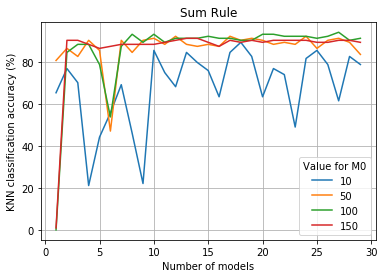

In [175]:
plt.figure()
plt.plot(T_range, sum_score_vec[0]*100, label="10")
plt.plot(T_range, sum_score_vec[1]*100, label="50")
plt.plot(T_range, sum_score_vec[2]*100, label="100")
plt.plot(T_range, sum_score_vec[3]*100, label="150")
plt.xlabel("Number of models")
plt.ylabel("KNN classification accuracy (%)")
plt.title("Sum Rule")
plt.legend(title="Value for M0")
plt.grid()

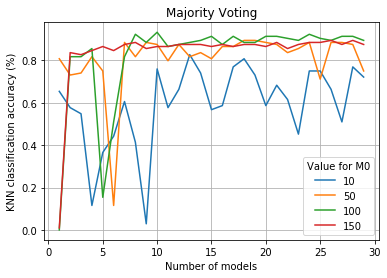

In [176]:
plt.figure()
plt.plot(T_range, maj_score_vec[0], label="10")
plt.plot(T_range, maj_score_vec[1], label="50")
plt.plot(T_range, maj_score_vec[2], label="100")
plt.plot(T_range, maj_score_vec[3], label="150")
plt.xlabel("Number of models")
plt.ylabel("KNN classification accuracy (%)")
plt.title("Majority Voting")
plt.legend(title="Value for M0")
plt.grid()

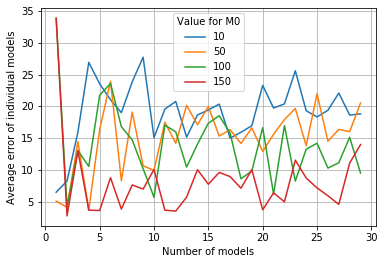

In [177]:
plt.figure()
plt.plot(T_range, tmp_vec[0], label="10")
plt.plot(T_range, tmp_vec[1], label="50")
plt.plot(T_range, tmp_vec[2], label="100")
plt.plot(T_range, tmp_vec[3], label="150")
plt.xlabel("Number of models")
plt.ylabel("Average error of individual models")
plt.legend(title="Value for M0")
plt.grid()

In [ ]:
##### HYPER PARAMS #####
m_pca = 201
m_lda=37
M0 = 180

n_neighbours = 2

T_range = list(range(1,30,1))
########################

full_PCA = PCA(n_components=416).fit(train_faces)
components = full_PCA.components_
eigen_vals = full_PCA.explained_variance_

sum_scores = np.zeros(shape=(len(T_range)), dtype=float)
majority_scores = np.zeros(shape=(len(T_range)), dtype=float)

sum_errors = np.zeros(shape=(len(T_range)), dtype=float)
majority_errors = np.zeros(shape=(len(T_range)), dtype=float)

avg_errors = np.zeros(shape=(len(T_range)), dtype=float)

for n_models in tqdm(T_range):
    fixed_components = components[:M0]
    predictions = []
    error_vec = np.empty(shape=(n_models), dtype=float)
    for model in range(n_models):
        sampled_components, sampled_eigenvalues = get_random_subset(components, eigen_vals, M0, 416, n=m_pca-M0)
        subspace_components = np.concatenate((fixed_components, sampled_components), axis=0)
        proj = np.dot(subspace_components, train_faces.T).T
        proj_test = np.dot(subspace_components, test_faces.T).T
        lda = LDA(n_components=m_lda)
        x_train = lda.fit_transform(proj, train_labels)
        x_test = lda.transform(proj_test)
        knn = KNeighborsClassifier(n_neighbors=n_neighbours)
        knn.fit(x_train, train_labels)
        pred = knn.predict_proba(x_test)
        error_vec[model] = metrics.log_loss(test_labels, pred)
        predictions.append(pred)
        
    sum_classPredicted = sum_fusion(predictions)
    majority_classPredicted = majority_fusion(predictions)
    
    sum_score = metrics.accuracy_score(test_labels, sum_classPredicted)
    majority_score = metrics.accuracy_score(test_labels, majority_classPredicted)
    
    sum_scores[T_range.index(n_models)] = sum_score
    majority_scores[T_range.index(n_models)] = majority_score
    
    avg_errors[T_range.index(n_models)] = np.mean(error_vec)

In [ ]:
?np.argmax